In [12]:

%load_ext autoreload
%autoreload 2


In [157]:
from keras.models import model_from_json
from keras.preprocessing import image
from keras import models

import modified_sgd 
import data_loader
import function_for_visualization

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline


In [5]:
# load model structure and weights 

json_file = open('./models/siamese_net_lr10e-4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./models/siamese_net_lr10e-4.h5")
print("model loaded from disk")


model loaded from disk


In [6]:
# evaluate loaded model on test data
# define the optimizer and compile the model

learning_rate = 10e-4

# Learning Rate multipliers for each layer
learning_rate_multipliers = {}
learning_rate_multipliers['Conv1'] = 1
learning_rate_multipliers['Conv2'] = 1
learning_rate_multipliers['Conv3'] = 1
learning_rate_multipliers['Conv4'] = 1
learning_rate_multipliers['Dense1'] = 1

optimizer = modified_sgd.Modified_SGD(lr = learning_rate, lr_multipliers = learning_rate_multipliers, momentum = 0.5)

loaded_model.compile(loss = 'binary_crossentropy', metrics = ['binary_accuracy'], optimizer = optimizer)


In [9]:
# testing on the 20 alphabets kept aside

testing_accuracy = data_loader.one_shot_test(loaded_model, 20, 40, False)
testing_accuracy



one shot on evaluation alphabets:
Oriya alphabet, accuracy: 0.525
ULOG alphabet, accuracy: 0.725
Tengwar alphabet, accuracy: 0.7
Malayalam alphabet, accuracy: 0.8
Atlantean alphabet, accuracy: 0.5
Keble alphabet, accuracy: 0.875
Manipuri alphabet, accuracy: 0.625
Gurmukhi alphabet, accuracy: 0.725
Tibetan alphabet, accuracy: 0.65
Aurek-Besh alphabet, accuracy: 0.825
Ge_ez alphabet, accuracy: 0.725
Angelic alphabet, accuracy: 0.775
Old_Church_Slavonic_(Cyrillic) alphabet, accuracy: 0.875
Kannada alphabet, accuracy: 0.575
Avesta alphabet, accuracy: 0.675
Mongolian alphabet, accuracy: 0.675
Syriac_(Serto) alphabet, accuracy: 0.7
Atemayar_Qelisayer alphabet, accuracy: 0.825
Sylheti alphabet, accuracy: 0.65
Glagolitic alphabet, accuracy: 0.675

Mean global accuracy: 0.705


0.705

### look at the characters from one alphabet in testing

In [136]:
# get image paths for one alphabet in testing, one batch is one alphabet

batch_images_path = function_for_visualization.get_one_shot_batch_image_path(support_set_size = 20, is_validation = False,\
                                                                            current_alphabet_index = 3)


In [137]:
# visualize pairs of images for testing image verification

def grid_display(support_set_size, list_images_path, predicted_label_list, width, height):
    
    nrows = 2 
    ncols = int(support_set_size)
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
  
    for row in range(nrows):
        for col in range(ncols):
            if (row)% 2 == 0:
                # if row is an odd number
                img = Image.open(batch_images_path[0])
                ax[row, col].imshow(img)
                ax[row, col].set_title(batch_images_path[0].split('/')[-2][-2: ])
            else:
                # if row is an even number 
                img = Image.open(batch_images_path[col * 2 + 1])
                ax[row, col].imshow(img)
                ax[row, col].set_title('{}, pred_label: {}'.format(batch_images_path[col * 2 + 1].split('/')[-2][-2: ], predicted_label_list[col]))                
            

In [138]:
# making prediction and adding the predicted label into the plots

def predict_label(image_paths, support_set_size):
    # convert images to np.arrays and their corresponding labels image_paths
    image_pairs, labels = data_loader.__convert_path_list_to_images_and_labels(batch_images_path, is_one_shot_task = True)

    # prediction using pairs of np.arrays just converted 
    probabilities = loaded_model.predict_on_batch(image_pairs)

    # create the label list to use as titles in the visualizations 
    # label list creation
    predicted_labels = [0 for i in range(support_set_size)]
    # update with actual predictions
    predicted_labels[np.argmax(probabilities)] = 1

    return predicted_labels


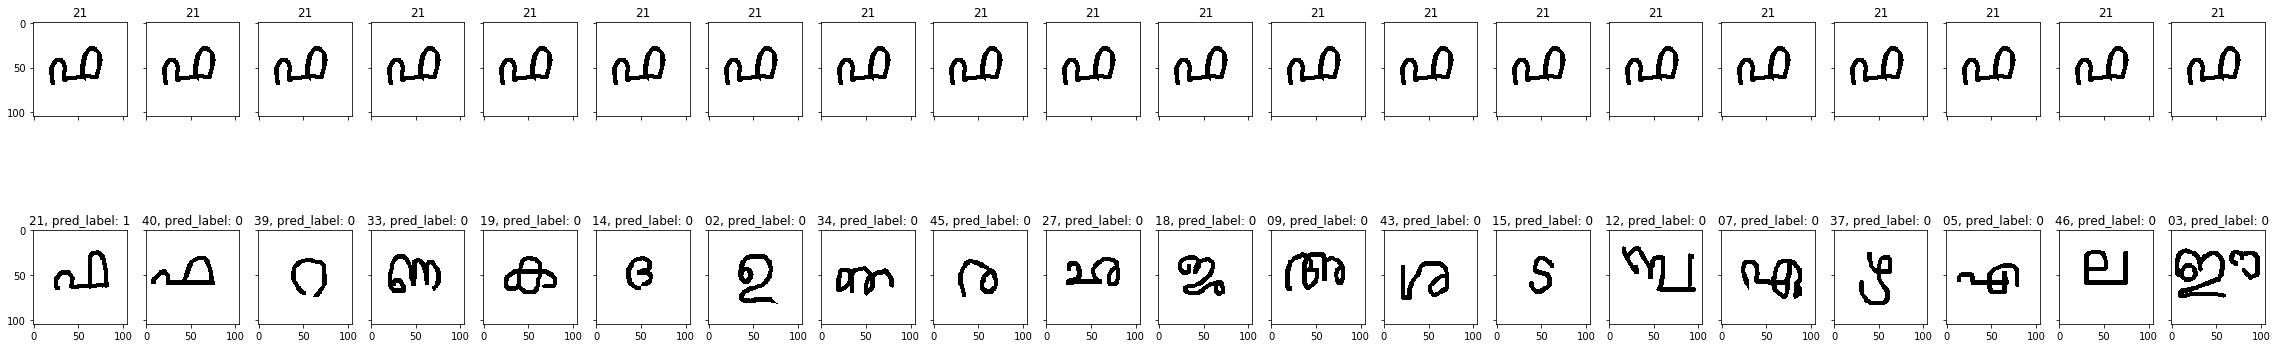

In [139]:
# visualize

predicted_labels = predict_label(image_paths = batch_images_path, support_set_size = 20)

grid_display(support_set_size = 20, list_images_path = batch_images_path, predicted_label_list = predicted_labels, width = 40, height = 7)


### visualize activations

In [183]:
# process one pair of images
       
def process_image_pair(img_path1, img_path2):
    
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    
    img1 = np.asarray(img1).astype(np.float64)
    img1 = img1/ img1.std() - img1.mean() 
    img2 = np.asarray(img2).astype(np.float64)
    img2 = img2/ img2.std() - img2.mean() 
    
    # put two images into a list of np.array - pair
    image_pair = [np.zeros((1, 105, 105, 1)) for i in range(2)]
    image_pair[0][0,:, :, 0] = img1
    image_pair[1][0,:, :, 0] = img2
    
    return image_pair
    


In [185]:
one_image_pair = process_image_pair(batch_images_path[0], batch_images_path[3])


In [75]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         10636096    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

In [195]:
layer_outputs = [layer.output for layer in loaded_model.layers[: 2]]
activation_model = models.Model(inputs = loaded_model.input, outputs = layer_outputs)
activations = activation_model.predict(one_image_pair)

activations[0].shape

# plt.matshow(activations[0][0:, :, :, 0])

(1, 105, 105, 1)